# Turnbull

In [452]:
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
from matplotlib.backends.backend_pdf import PdfPages

from scipy.stats import truncnorm

In [498]:
%run ../source/models/iceberg/iceberg.py
%run ../source/models/metocean/metocean.py
%run ../source/models/drift/turnbull.py
%run ../source/plotting/plot.py

# Iceberg

In [465]:
chosen_track_ind = 16
iip_berg_df = get_berg_df(2015, chosen_track_ind)
iip_berg_df

,index,ICEBERG_YEAR,ICEBERG_NUMBER,SIGHTING_DATE,SIGHTING_TIME,SIGHTING_LATITUDE,SIGHTING_LONGITUDE,SIGHTING_METHOD,SIZE,SHAPE,SOURCE,TIMESTAMP
0,10483,2015,23460,6/25/2015,1111,47.52,-49.42,R/V,LG,GEN,GTJZ,2015-06-25 11:11:00
1,10484,2015,23460,6/25/2015,1859,47.53,-49.49,R/V,LG,GEN,GPGR,2015-06-25 18:59:00
2,10485,2015,23460,6/26/2015,1046,47.46,-49.53,R/V,GEN,GEN,GTJZ,2015-06-26 10:46:00
3,10486,2015,23460,6/27/2015,1036,47.44,-49.51,R/V,LG,GEN,GPGR,2015-06-27 10:36:00
4,10487,2015,23460,6/27/2015,1331,47.42,-49.53,RAD,GEN,GEN,2005,2015-06-27 13:31:00


In [499]:
iip_berg = Iceberg(iip_berg_df['ICEBERG_NUMBER'].loc[0],
                    iip_berg_df['TIMESTAMP'].dt.to_pydatetime(),
                    [0], [0],
                    iip_berg_df['SIGHTING_LATITUDE'].loc[:].tolist(),
                    iip_berg_df['SIGHTING_LONGITUDE'].loc[:].tolist(),
                    iip_berg_df['SIZE'].loc[0],
                    iip_berg_df['SHAPE'].loc[0])

# Metocean

In [467]:
ocean_data = ECMWF_Ocean(min(iip_berg.lons), max(iip_berg.lons),
                         min(iip_berg.lats), max(iip_berg.lats),
                         iip_berg.datetimes[0], iip_berg.datetimes[-1])

In [468]:
ocean_data.filenames

['ftp://data.munroelab.ca/pub/ECMWF/ocean/daily/20150625.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/ocean/daily/20150626.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/ocean/daily/20150627.nc']

In [469]:
atm_data = ECMWF_Atm(min(iip_berg.lons), max(iip_berg.lons),
                     min(iip_berg.lats), max(iip_berg.lats),
                     iip_berg.datetimes[0], iip_berg.datetimes[-1])

In [470]:
atm_data.filenames

['ftp://data.munroelab.ca/pub/ECMWF/atm/daily/sub20150625.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/atm/daily/sub20150626.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/atm/daily/sub20150627.nc']

# Driver

In [500]:
vary_wind = True
vary_current = True

# Run number
run_num = 0
num_runs = 50
mod_berg_list = []


# Buffer number for bounding spatial box
buf = 0.5


for run_num in range(num_runs):

    # Create model iceberg
    mod_berg = Iceberg(iip_berg_df['ICEBERG_NUMBER'][0],
                        [iip_berg_df['TIMESTAMP'].dt.to_pydatetime()[0]],
                        [0], [0],
                        [iip_berg_df['SIGHTING_LATITUDE'][0]],
                        [iip_berg_df['SIGHTING_LONGITUDE'][0]],
                        iip_berg_df['SIZE'][0], iip_berg_df['SHAPE'].loc[0])

    mod_berg.length = [mod_berg.length]
    mod_berg.width = [mod_berg.width]
    mod_berg.height = [mod_berg.height]


    # Timesteps
    t0 = iip_berg.datetimes[0]
    tf = iip_berg.datetimes[-1]
    t_delta = tf - t0
    t_delta_hours = t_delta.days*24 + t_delta.seconds/3600
    t_step_hours = 0.1
    t_step = timedelta(hours = t_step_hours)
    dt = t_step_hours*3600  # timestep in seconds
    t_all = []
    for i in np.arange(0, t_delta_hours + t_step_hours, t_step_hours):
        new_date = t0 + timedelta(hours=i)
        t_all.append(new_date)

    # Input field offsets
    # Note: average iceberg speed around NL is 0.2 m/s
    # Note: reasonable mean u,v velocities of current are: 0.11, -0.13 m/s 
    vwu_offset = truncnorm.rvs(-1,1, loc=ocean_data.mean_u, scale=ocean_data.std_u) 
    vwv_offset = truncnorm.rvs(-1,1, loc=ocean_data.mean_v, scale=ocean_data.std_v) 
    vw_offset = np.sqrt(vwu_offset**2 + vwv_offset**2)
    vw_dir_offset = truncnorm.rvs(-np.pi, np.pi, loc=ocean_data.mean_dir, scale=0.5)
    vwu_offset = vw_offset*np.cos(vw_dir_offset)
    vwv_offset = vw_offset*np.sin(vw_dir_offset)
    
    vau_offset = truncnorm.rvs(-20,20, loc=atm_data.mean_u, scale=atm_data.std_u) 
    vav_offset = truncnorm.rvs(-20,20, loc=atm_data.mean_v, scale=atm_data.std_v) 
    va_offset = np.sqrt(vau_offset**2 + vav_offset**2)
    va_dir_offset = truncnorm.rvs(-np.pi, np.pi, loc=atm_data.mean_dir, scale=0.5)
    vau_offset = va_offset*np.cos(va_dir_offset)
    vav_offset = va_offset*np.sin(va_dir_offset)
    
    # Iceberg Initials
    x0, y0 = mod_berg.lons[0], mod_berg.lats[0]
    l0, w0, h0 = mod_berg.length[0], mod_berg.width[0], mod_berg.height[0]
    vx0 = vwu_offset
    vy0 = vwv_offset
    
    l, w, h = l0, w0, h0
    x, y = x0, y0
    vx, vy = vx0, vy0
    
        
    print('Run number: {}, h = {}, l = {}, w = {}'.format(run_num, h0, l0, w0))

    for t in t_all:


        t_ocean = nc.date2num(t, 'hours since 1950-01-01 00:00:00.0 00:00', 'standard')
        t_atm = nc.date2num(t, 'hours since 1900-01-01 00:00:00.0 00:00', 'standard')
        
        vau = atm_data.iUA([t_atm, y, x])[0]
        vav = atm_data.iVA([t_atm, y, x])[0]
        vwu = ocean_data.iUW([t_ocean, y, x])[0]
        vwv = ocean_data.iVW([t_ocean, y, x])[0]
        #print('vwu, vwv = {}, {}'.format(np.round(vwu,2), np.round(vwv,2)))
        
        if vary_current:
            vwu += vwu_offset
            vwv += vwv_offset
        
        if vary_wind:
            vau += vau_offset
            vav += vav_offset
        
        #print('Timestep: {}'.format(t))

        vx, vy, x, y = turnbull_drift(mod_berg, vau, vav, vwu, vwv, dt) 


        if x > max(iip_berg.lons)+buf or x < min(iip_berg.lons)-buf or y > max(iip_berg.lats)+buf or y <= min(iip_berg.lats)-buf:
            # Iceberg out-of-bounds
            print('out-of-bounds')
            break


        else:
            mod_berg.xvels.append(vx)
            mod_berg.yvels.append(vy)
            mod_berg.lons.append(x)
            mod_berg.lats.append(y)
            mod_berg.datetimes.append(t)

    #mod_berg.datetimes.pop(0)
    print("Final time: {}".format(t)) 

    mod_berg_list.append(mod_berg)

Run number: 0, h = 378.1186129986794, l = 129.2113420450409, w = 130.31999496211543
out-of-bounds
Final time: 2015-06-27 08:23:00
Run number: 1, h = 380.77310053082743, l = 122.59649819776644, w = 123.70303086388648
Final time: 2015-06-27 13:35:00
Run number: 2, h = 287.5032641458251, l = 167.18241454748545, w = 183.50214595286127
Final time: 2015-06-27 13:35:00
Run number: 3, h = 340.28078135869777, l = 123.46331353645212, w = 153.01207436728072
Final time: 2015-06-27 13:35:00
Run number: 4, h = 276.6050904469575, l = 156.84034673031346, w = 147.05481149797583
Final time: 2015-06-27 13:35:00
Run number: 5, h = 395.4077580552465, l = 178.11895464174683, w = 155.31214374741313
Final time: 2015-06-27 13:35:00
Run number: 6, h = 369.6206396533728, l = 182.1464332208219, w = 160.20402875045426
Final time: 2015-06-27 13:35:00
Run number: 7, h = 401.0685281637099, l = 180.67079257285076, w = 161.13964815695212
Final time: 2015-06-27 13:35:00
Run number: 8, h = 302.3965855485711, l = 194.3540

# Plotting

In [501]:
vx0

0.094666444420747606

In [502]:
vy0

-0.16275699984495351

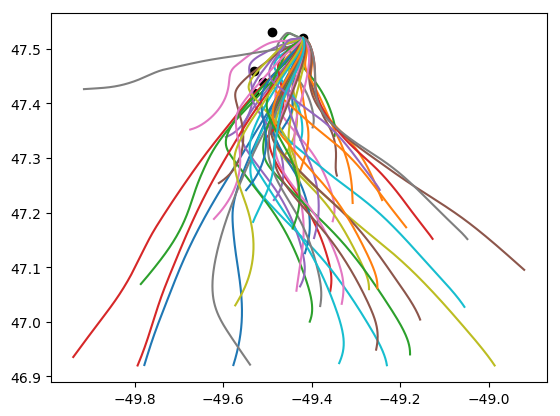

In [503]:
for berg in mod_berg_list:
    plt.plot(berg.lons, berg.lats)
plt.scatter(iip_berg.lons, iip_berg.lats, color='black')
plt.savefig('plots/spaghetti_ind{}.png'.format(chosen_track_ind))

In [490]:
mod_berg.keel_area

9222.891031415416

In [491]:
mod_berg.length[0] * mod_berg.keel_depth/2

23057.22757853854

In [492]:
mod_berg.length

[179.38164950410822]

In [493]:
mod_berg.keel_depth

257.07454070446016

In [494]:
mod_berg.sail_height

51.41490814089204

In [495]:
mod_berg.height

[308.4894488453522]

In [497]:
mod_berg.sail_area

23057.22757853854

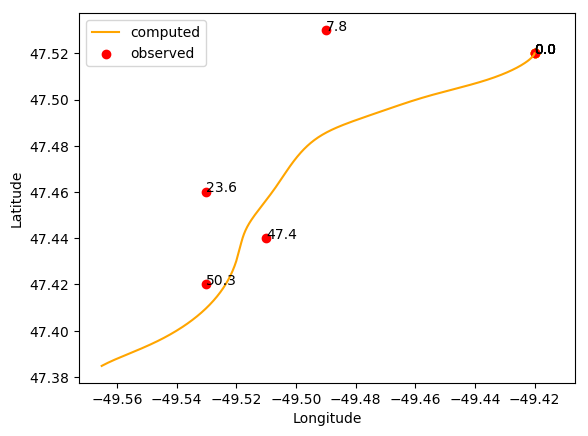

In [439]:
plot = plot_turnbull(iip_berg, mod_berg_list[0])

In [245]:
# vw_theta
np.arctan(abs(vy0/vx0))

1.0547085198915833

In [251]:
# vw_mag
np.sqrt(vy0**2 + vx0**2)

0.21939049130728697

In [246]:
#vw_mag_offset
np.random.normal(loc=np.sqrt(vy0**2 + vx0**2), scale=0.05)

0.17790384144619015

In [248]:
# vw_theta_deg
np.arctan(vy0/vx0)*180/np.pi

-60.430346806277555

In [249]:
# vw_theta_offset
np.random.normal(loc=0.0, scale=5*np.pi/180)

-0.06192743472523413

In [250]:
# vwu_new 
(np.sqrt(vy0**2 + vx0**2) + \
 np.random.normal(loc=np.sqrt(vy0**2 + vx0**2), scale=0.05)) *\
np.cos(np.arctan(abs(vy0/vx0)) + np.random.normal(loc=0.0, scale=5*np.pi/180))

0.12742772075981748

In [252]:
(np.sqrt(vy0**2 + vx0**2) + \
 np.random.normal(loc=np.sqrt(vy0**2 + vx0**2), scale=0.05)) *\
np.sin(np.arctan(abs(vy0/vx0)) + np.random.normal(loc=0.0, scale=5*np.pi/180))

0.33260878871580069

In [256]:
np.sqrt((np.sqrt(vy0**2 + vx0**2) + \
 np.random.normal(loc=np.sqrt(vy0**2 + vx0**2), scale=0.05)) *\
np.cos(np.arctan(abs(vy0/vx0)) + np.random.normal(loc=0.0, scale=5*np.pi/180))**2 +\
       (np.sqrt(vy0**2 + vx0**2) + \
 np.random.normal(loc=np.sqrt(vy0**2 + vx0**2), scale=0.05)) *\
np.sin(np.arctan(abs(vy0/vx0)) + np.random.normal(loc=0.0, scale=5*np.pi/180))**2)

0.69919114819719297

In [257]:
np.std(atm_data.UA[0,0,:])

2.5081118364967301

In [258]:
np.mean(atm_data.UA[0,0,:])

-0.12112500000000001

In [292]:
np.mean(ocean_data.UW[:,:,:])

-5904.8301

In [287]:
np.mean(ocean_data.ds.variables['uo'][:,0,:,:].flatten())

0.048373834528420291

In [289]:
np.min(ocean_data.ds.variables['uo'][:,0,:,:])

-1.131016

In [290]:
ocean_data.ds.variables['uo']

<class 'netCDF4._netCDF4._Variable'>
int16 uo('time', 'depth', 'latitude', 'longitude')
    standard_name: eastward_sea_water_velocity
    long_name: Eastward velocity
    units: m s-1
    add_offset: 0.0
    scale_factor: 0.00061037
    _FillValue: -32767
    missing_value: -32767
    _CoordinateAxes: time depth latitude longitude 
    unit_long: Meters per second
    cell_methods: area: mean
unlimited dimensions = ('time',)
current size = (72, 1, 301, 301)

In [283]:
np.mean(atm_data.UA.flatten() > -100)

0.92786458333333333

In [284]:
np.mean(atm_data.VA.flatten() > -100)

0.92786458333333333

In [277]:
np.mean(ocean_data.VW.flatten() > -100)

0.8197922760234434

In [278]:
np.mean(ocean_data.UW.flatten() > -100)

0.8197922760234434

In [270]:
atm_data.UA[0,0,20]

-1.01

In [271]:
atm_data.VA[0,0,20]

-6.9900000000000002

In [ ]:
def wind_error(ua, va):
    ua_mean = np.mean(ua)
    va_mean = np.mean(va)
    mag = np.sqrt(ua_mean**2 + va_mean**2)
    direction = np.arctan(ua_mean/va_mean)
    mag_mean = np.mean(mag)
    mag_std = np.std(mag)
    
    return np.random.normal(loc=0.0, scale=22.96*np.pi/180)

def wind_mag_error():
    return np.random.normal(loc=1.66, scale=2.99)

def current_dir_error():
    return 

In [237]:
vx0

0.10826509780818014

In [187]:
np.mean(abs(atm_data.UA[0,0,:]))

2.1968749999999999

(array([  7.,   6.,  15.,   9.,   4.,  11.,  14.,   6.,   4.,   4.]),
 array([ 0.02 ,  0.498,  0.976,  1.454,  1.932,  2.41 ,  2.888,  3.366,
         3.844,  4.322,  4.8  ]),
 <a list of 10 Patch objects>)

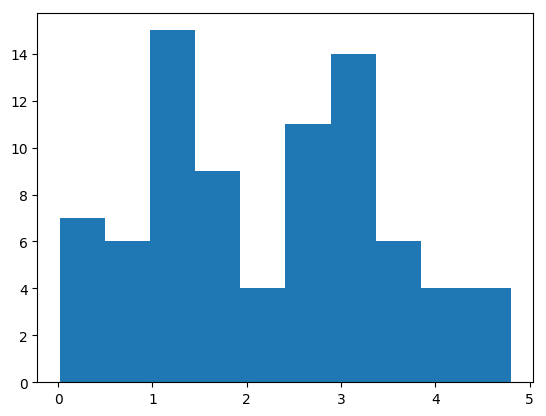

In [186]:
plt.hist(np.sqrt(atm_data.UA[0,0,:]**2))

In [94]:
ocean_data.UW.shape

(72, 301, 301)

In [95]:
iip_berg.lons

[-50.01, -50.02, -49.76]

In [96]:
iip_berg.lats

[48.16, 48.09, 48.08]

In [97]:
ocean_data.ds.variables

OrderedDict([('longitude', <class 'netCDF4._netCDF4.Variable'>
              float32 longitude(longitude)
                  standard_name: longitude
                  long_name: longitude
                  units: degrees_east
                  axis: X
              unlimited dimensions: 
              current shape = (301,)
              filling off), ('latitude', <class 'netCDF4._netCDF4.Variable'>
              float32 latitude(latitude)
                  standard_name: latitude
                  long_name: latitude
                  units: degrees_north
                  axis: Y
              unlimited dimensions: 
              current shape = (301,)
              filling off), ('depth', <class 'netCDF4._netCDF4.Variable'>
              float32 depth(depth)
                  standard_name: depth
                  long_name: Depth
                  units: m
                  positive: down
                  axis: Z
                  unit_long: Meters
                  _CoordinateAxi

In [98]:
np.mean(ocean_data.UW)

-5904.8301

(array([  2.,  16.,  37.,  32.,  39.,  66.,  44.,  24.,  10.,  31.]),
 array([-0.86489457, -0.67262796, -0.48036134, -0.28809473, -0.09582812,
         0.0964385 ,  0.28870511,  0.48097172,  0.67323834,  0.86550495,
         1.05777156]),
 <a list of 10 Patch objects>)

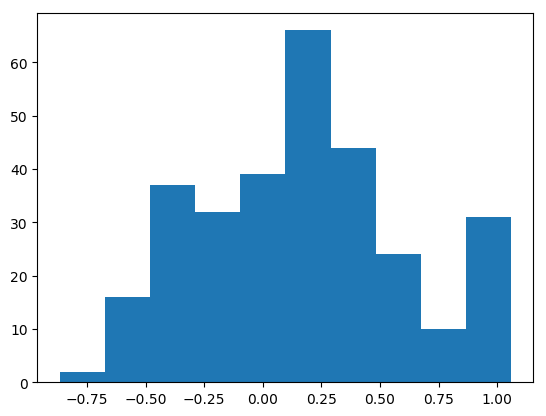

In [101]:
plt.hist(ocean_data.UW[0,0,:])

(array([ 196.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  105.]),
 array([ -3.27670000e+04,  -2.94902548e+04,  -2.62135095e+04,
         -2.29367643e+04,  -1.96600191e+04,  -1.63832739e+04,
         -1.31065286e+04,  -9.82978340e+03,  -6.55303817e+03,
         -3.27629294e+03,   4.52284306e-01]),
 <a list of 10 Patch objects>)

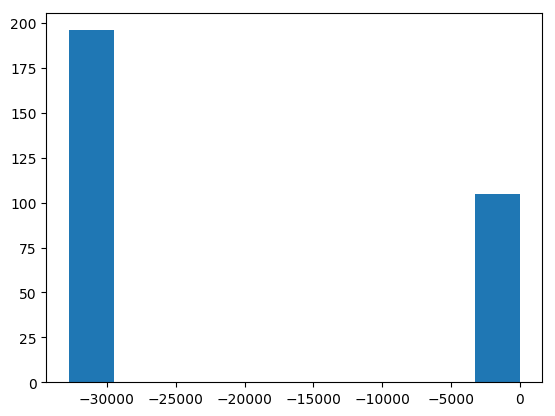

In [102]:
plt.hist(ocean_data.UW[0,:,0])

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  43.]),
 array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0]),
 <a list of 10 Patch objects>)

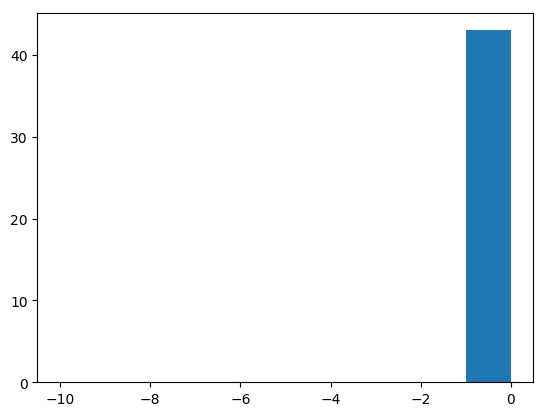

In [105]:
plt.hist(ocean_data.UW[0,:,0], bins=[-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0])

(array([  0.,   0.,   1.,   1.,   1.,   2.,  38.]),
 array([-1.4, -1.2, -1. , -0.8, -0.6, -0.4, -0.2,  0. ]),
 <a list of 7 Patch objects>)

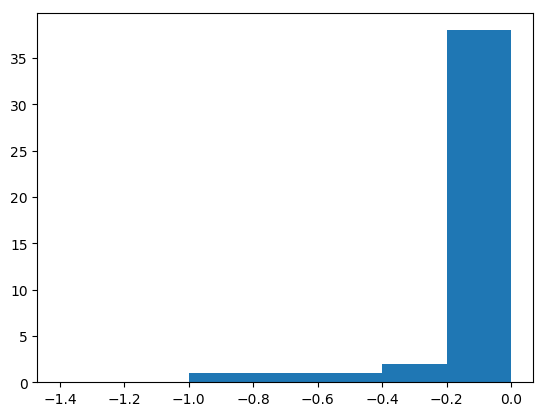

In [106]:
plt.hist(ocean_data.UW[0,:,0], bins=[-1.4,-1.2,-1,-0.8,-0.6,-0.4,-0.2,0])

In [107]:
np.mean(ocean_data.UW[ocean_data.UW > -1][ocean_data.UW[ocean_data.UW > -1] < 0])

-0.10683133

In [111]:
np.mean(ocean_data.VW[ocean_data.VW > -1][ocean_data.VW[ocean_data.VW > -1] < 0])

-0.12550569

In [108]:
np.random.normal(np.mean(ocean_data.UW[ocean_data.UW > -1][ocean_data.UW[ocean_data.UW > -1] < 0]), 0.58)

-0.3584328065221435

In [110]:
truncnorm.rvs(-1,0,loc=np.mean(ocean_data.UW[ocean_data.UW > -1][ocean_data.UW[ocean_data.UW > -1] < 0]))

-0.77371027176425189

# Animations

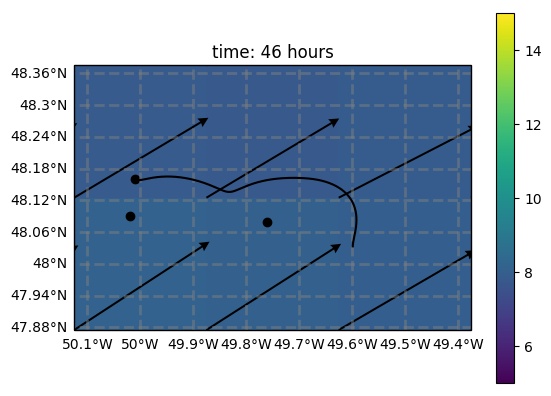

In [27]:
animate_winds(atm_data, iip_berg, mod_berg)

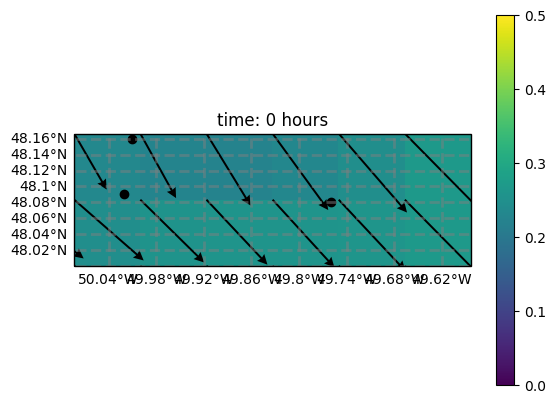

In [28]:
animate_currents(ocean_data, iip_berg, mod_berg)